This project analyzes NVIDIA's (NVDA) stock performance from 2023 to 2024, a period marked by its central role in the surge of AI technologies. We examined its growth and volatility relative to broader market trends and explored key financial drivers behind its rise. Using historical and financial data, we aimed to assess NVIDIA’s future outlook and identify potential indicators of continued growth. Our analysis combines market context with company-specific fundamentals to evaluate NVDA’s position moving forward.



In [16]:
import csv
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import re
import json
import plotly.express as px

In [17]:

def data_parser():
    filename = 'combined_sp100_sp500_qqq_nyse_dji_ixic_spy_full_data_1982_2025.csv'
    df = pd.read_csv(filename)
    
    ''' we only want to obtain the following columns: 
        date column - "Date"
        Closing price of the S&P 100 - "('Close', '^OEX')_S&P100"
        Closing price of the s&P 500- "('Close', '^GSPC')_S&P500"
        Closing price of QQQ - "('Close', 'QQQ')_QQQ"
        Closing price of NYSE - "('Close', '^NYA')_NYSE"
        Closing price of DJI - "('Close', '^DJI')_DJI"
        Closing price of IXIC (Nasdaq Composite) - "('Close', '^IXIC')_IXIC"
        Closing price fo SPY (index tracking the sp500 fund) - "('Close', 'SPY')_SPY"
    '''
    df = df[["Date", 
                                   "('Close', '^OEX')_S&P100", 
                                   "('Close', '^GSPC')_S&P500", 
                                   "('Close', 'QQQ')_QQQ", 
                                   "('Close', '^NYA')_NYSE",
                                   "('Close', '^DJI')_DJI",
                                   "('Close', '^IXIC')_IXIC",
                                   "('Close', 'SPY')_SPY"]]
    #Now I want to rename the columns to make them more readable
    df = df.rename(columns = {"('Close', '^OEX')_S&P100" : "S&P 100",
                                               "('Close', '^GSPC')_S&P500" : "S&P 500",
                                               "('Close', 'QQQ')_QQQ" : "QQQ",
                                                "('Close', '^NYA')_NYSE" : "NYSE",
                                               "('Close', '^DJI')_DJI" : "DJI",
                                               "('Close', '^IXIC')_IXIC" : "IXIC",
                                               "('Close', 'SPY')_SPY" : "SPY"},)
    #we need to standardize the date to yyyy-mm-dd
    df['Date'] = pd.to_datetime(df['Date'])
    #only get the rows where the year is 2023 and 2024
    df = df[(df['Date'].dt.year == 2023) | (df['Date'].dt.year == 2024)]
    #make the date column the index of the data frame 
    df.set_index('Date', inplace=True)

    #get rid of the NaN values 
    for i in range (1, 502):
        if pd.isna(df.iloc[i]['S&P 100']):
            df.iloc[i,0] = ((df.iloc[i - 1,0]) + (df.iloc[i + 1,0])) / 2


    #we want to round all values to 2 decimal places
    df = df.round(2)

    df.to_csv('market_closing.csv', index=True)
    return(df)

    
                                               
    
                                               
                                               
                                               



############ Function Call ############
data_parser()

,S&P 100,S&P 500,QQQ,NYSE,DJI,IXIC,SPY
Date,,,,,,,
2023-01-03,1701.93,3824.14,261.11,15154.45,33136.37,10386.98,370.37
2023-01-04,1710.27,3852.97,262.36,15350.30,33269.77,10458.76,373.23
2023-01-05,1690.65,3808.10,258.25,15225.40,32930.08,10305.24,368.97
2023-01-06,1727.65,3895.08,265.38,15539.74,33630.61,10569.29,377.43
2023-01-09,1726.18,3892.09,267.10,15514.44,33517.65,10635.65,377.21
...,...,...,...,...,...,...,...
2024-12-24,2978.45,6040.04,529.96,19341.48,43297.03,20031.13,601.30
2024-12-26,2976.46,6037.59,529.60,19364.50,43325.80,20020.36,601.34
2024-12-27,2940.20,5970.84,522.56,19238.48,42992.21,19722.03,595.01


In [18]:
import requests 
import re
import pandas as pd
from bs4 import BeautifulSoup
import json

def web_parser1():
    url = 'https://www.macrotrends.net/stocks/charts/NVDA/nvidia/income-statement?freq=Q'


    #to avoid a block from a website
    headers = {
    'User-Agent': 'Mozilla/5.0'
    }

    response = requests.get(url, headers=headers)

    #get the html content
    soup = BeautifulSoup(response.text, 'html.parser')
    # the data is hidden in a JavaScript variable called originalData so we will need to extract that
    scripts  = soup.find_all('script') #this in the form of a set
    #look for the script that contains original data
    for script in scripts:
        if 'originalData' in script.text:
            #return(script.text)
            # we want to extract everything out of 'var original data = [...] ---> we want what is in the ...
            one_line = script.text.replace('\n', '') # in case there is a new line character for regex matching
            match = re.search(r'var originalData = (\[.*?\]);', one_line)
            if match:
                #get the first capture group of the march and load it into a dict
                json_dict = json.loads(match.group(1))
                break
    df = pd.DataFrame(json_dict)
    # we only want the years 2023 and 2024

    df = df[['field_name','2023-01-31', '2023-04-30', '2023-07-31', '2023-10-31', '2024-01-31','2024-04-30', '2024-07-31', '2024-10-31']]
    #clean the field_name column by getting rid of the <> tags
    df['field_name'] = df['field_name'].str.replace(r'<.*?>', '', regex=True)

    #we only want the Revenue, Gross Profit and EPS
    df = df.loc[
    (df['field_name'] == 'Revenue') |
    (df['field_name'] == 'Gross Profit') |
    (df['field_name'] == 'Basic EPS') |
    (df['field_name'] == 'EPS - Earnings Per Share')

]

    #cols_to_keep = ['field_name'] + [col for col in df.columns if col.startswith('2023') or col.startswith('2024')]
    #df = df[cols_to_keep]

    #rename the field_name column to Date
    df = df.rename(columns = {'field_name' : 'Date'})

    #formatting
    df = df.T
    df.columns = df.iloc[0] #set the field name to be column titles
    df = df.drop(df.index[0]) #remove excess row
    df = df.apply(pd.to_numeric).round(2)

    #round everything to 2 decimal places


    df.to_csv('nvda_income.csv', index=True)

    return(df)



############ Function Call ############
web_parser1()

Date,Revenue,Gross Profit,Basic EPS,EPS - Earnings Per Share
2023-01-31,6051.0,3833.0,0.06,0.05
2023-04-30,7192.0,4648.0,0.08,0.08
2023-07-31,13507.0,9462.0,0.25,0.25
2023-10-31,18120.0,13400.0,0.37,0.37
2024-01-31,22103.0,16791.0,0.51,0.49
2024-04-30,26044.0,20406.0,0.60,0.60
2024-07-31,30040.0,22574.0,0.68,0.67
2024-10-31,35082.0,26156.0,0.79,0.78


In [19]:
def web_parser2():
    with open("nvidia_stock_data_2023_2024.json", 'r') as f:
        #formatting intitial into dataframe for parsing
        data = json.load(f)
        df = pd.DataFrame(data)

    #we only want the closing price none of the other columns matter other than the date
    df = df[["('Date', '')", "('Close', 'NVDA')"]]

    #rename columns so its easier to understand
    df = df.rename(columns = {"('Date', '')": "Date", "('Close', 'NVDA')": "Closing_Price"})

    #need to remove the times out of the dates in the data
    df['Date'] = df['Date'].str.replace('T00:00:00.000', '', regex=False)
    

    #formatting

    #df = df.T
    #df = df.reset_index(drop = True) #remove index
    #df.columns = df.loc[0]
    #df = df.drop(df.index[0])

    #df = df.to_string(index=False) #removes the index entirely

    #round the closing price to 2 decimal places
    df['Closing_Price'] = df['Closing_Price'].round(2)
    df = df.rename(columns={'Closing_Price': 'NVDA'})
    
    #to csv
    df.to_csv('nvda_stock.csv', index=True)

    
    
    return df





############ Function Call ############
web_parser2()

,Date,NVDA
0,2023-01-03,14.30
1,2023-01-04,14.74
2,2023-01-05,14.25
3,2023-01-06,14.85
4,2023-01-09,15.62
...,...,...
496,2024-12-23,139.67
497,2024-12-24,140.22
498,2024-12-26,139.93
499,2024-12-27,137.01


In [20]:
def extra_source1():
    url = 'https://www.macrotrends.net/stocks/charts/NVDA/nvidia/financial-ratios?freq=Q'

    #to avoid a block from a website
    headers = {
    'User-Agent': 'Mozilla/5.0'
    }

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # the data is hidden in a JavaScript variable called originalData so we will need to extract that
    scripts  = soup.find_all('script') #extracting data
    for script in scripts:
        if 'originalData' in script.text:
            #return (script.text)
            # we want to extract everything out of 'var original data = [...] ---> we want what is in the ...
            one_line = script.text.replace('\n', '') # in case there is a new line character for regex matching
            match = re.search(r'var originalData = (\[.*?\]);', one_line)
            if match:
                #get the first capture group of the march and load it into a dict
                json_dict = json.loads(match.group(1))
                break
    df = pd.DataFrame(json_dict)
    # we only want the years 2023 and 2024
    df = df[['field_name','2023-01-31', '2023-04-30', '2023-07-31', '2023-10-31', '2024-01-31','2024-04-30', '2024-07-31', '2024-10-31']]
    #clean the field_name column by getting rid of the <> tags
    df['field_name'] = df['field_name'].str.replace(r'<.*?>', '', regex=True)
    #we only want the Net Profit Margin, ROE, ROI
    df = df.loc[
    (df['field_name'] == 'Net Profit Margin') |
    (df['field_name'] == 'ROE - Return On Equity') |
    (df['field_name'] == 'ROI - Return On Investment')

]
    #rename the field_name column to Date
    df = df.rename(columns = {'field_name' : 'Date'})

    #formatting
    df = df.T #transpose
    df.columns = df.iloc[0] #set the field name to be column titles
    df = df.drop(df.index[0]) #remove excess row
    df = df.apply(pd.to_numeric).round(2)


    #still need to write the data into a new file
    df.to_csv('nvda_financial_ratios.csv', index=True)


    return df
    
############ Function Call ############
extra_source1()

Date,Net Profit Margin,ROE - Return On Equity,ROI - Return On Investment
2023-01-31,23.37,6.40,4.45
2023-04-30,28.41,8.33,5.97
2023-07-31,45.81,22.50,17.21
2023-10-31,51.01,27.79,22.15
2024-01-31,55.59,28.59,23.89
2024-04-30,57.14,30.28,25.83
2024-07-31,55.26,28.54,24.92
2024-10-31,55.04,29.30,25.97


In [21]:
def insight1():

  # load NVDA stock data
  nvda = pd.read_csv('nvda_stock.csv', parse_dates=['Date'])
  #nvda_df = nvda_df[['Date', 'Closing_Price']].rename(columns={'Closing_Price': 'NVDA'}) #renaming because its too arbitrary

  # load other stock datas we have
  index = pd.read_csv('market_closing.csv', parse_dates=['Date'])

  # merge datasets on the date
  merged = pd.merge(nvda, index, on='Date', how='inner')

  # only want to look at qqq spy ixic and maybe dji
  cols = ['Date', 'NVDA', 'QQQ', 'SPY', 'IXIC', 'DJI']
  merged = merged[cols].dropna()

  # calculate daily returns
  returns = merged.set_index('Date').pct_change().dropna() #use pct change here to find the value

  # compute the correlation of NVDA with selected indices
  result = returns.corr()['NVDA'].drop('NVDA')

  # display result
  print("Correlation of NVIDIA (NVDA) with Major Indices (2023–2024):")
  print(result.round(4)) #round result amt



############ Function Call ############
insight1()

Correlation of NVIDIA (NVDA) with Major Indices (2023–2024):
QQQ     0.7084
SPY     0.5908
IXIC    0.6974
DJI     0.2831
Name: NVDA, dtype: float64


This analyzes how NVIDIA's daily stock movements correlate with key market indices like QQQ, SPY, IXIC, and DJI, which were chosen for their market prominence and tech relevance. To assess this, we merged their closing prices by date and calculated daily percentage returns using pct.change(). We then computed the Pearson correlation coefficient between NVDA’s returns and each index’s returns, where values closer to 1 indicate stronger alignment. QQQ showed the highest correlation at 0.7084, reflecting its tech-heavy composition and NVDA's influence in the sector. In contrast, the lower correlation with DJI suggests broader market forces may affect it more than NVIDIA alone.

In [22]:
def insight2():
    df1 = data_parser()
    df2 = web_parser2()

    df1 = df1.reset_index()
    df2 = df2.reset_index()
    df1['Date'] = pd.to_datetime(df1['Date'])
    df2['Date'] = pd.to_datetime(df2['Date'])

    merged = pd.merge(df1, df2, on='Date')  # joins two dfs based on a common column name, pandas documentation
    merged['NVDA_return'] = merged['NVDA'].pct_change() #pandas documentation, calculates the percentage change between a current and prior element
    merged['QQQ_return'] = merged['QQQ'].pct_change() #pandas documentation

    nvda_up = (merged['NVDA_return'] > 0.02).sum()
    nvda_down = (merged['NVDA_return'] < -0.02).sum()

    qqq_up = (merged['QQQ_return'] > 0.02).sum()
    qqq_down = (merged['QQQ_return'] < -0.02).sum()

    print("NVDA:")
    print(f"  Days with >2% gain: {nvda_up}")
    print(f"  Days with >2% loss: {nvda_down}")
    print("\n")
    print("QQQ:")
    print(f"  Days with >2% gain: {qqq_up}")
    print(f"  Days with >2% loss: {qqq_down}")



############ Function Call ############
insight2()

NVDA:
  Days with >2% gain: 137
  Days with >2% loss: 88


QQQ:
  Days with >2% gain: 27
  Days with >2% loss: 18


This compares the number of days where NVDA and QQQ experienced a larger daily movement. We decided that a large daily movement could be quantified by greater than +/-2% returns. 

Our results showed that NVDA had 137 dyas with >2% gains and 88 days with >2% losses, while QQQ only had 27 up days and 18 down days. This shows that NVDA tends to be a significantly more volatile stock, offering a higher upside but also highter downside risk. This is expected, as an individual growth stock tends to be more risky compared to a diversified ETF

In [23]:
def insight3():
  
    df1 = data_parser()
    df2 = web_parser2()

    df1 = df1.reset_index()
    df2 = df2.reset_index()
    df1['Date'] = pd.to_datetime(df1['Date'])
    df2['Date'] = pd.to_datetime(df2['Date'])

    merged = pd.merge(df1, df2, on='Date') # joins two dfs based on a common column name, pandas documentation
    merged['NVDA_return'] = merged['NVDA'].pct_change()
    merged['Weekday'] = merged['Date'].dt.day_name()

    avg_returns = merged.groupby('Weekday')['NVDA_return'].mean()

    #   weekday order
    avg_returns = avg_returns.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

    print("Average NVDA Return by Weekday:")
    print(avg_returns)





############ Function Call ############
insight3()

Average NVDA Return by Weekday:
Weekday
Monday       0.008985
Tuesday      0.004462
Wednesday    0.001461
Thursday     0.009273
Friday       0.001354
Name: NVDA_return, dtype: float64


This explores whether NVDA stock returns vary by the day of the week. By calculating the average daily return for each weekday, we found that Mondays and Thursdays tend to yield the highest returns while Friday and Wednesday have the lowest. 

This trend is related the the well known phenonmenon known as the Monday effect, referring to the tendency of stock prices to rise more on Monday, due to investors digesting news and economic developments over the weekend, resulting to stronger buying activity when the markets reopen. In this case, Mondays show high returns for NVIDIA. However, Thursday stands out as the top-performing day for NVDA, which could be due to market momentum building up during the week. 

In [24]:
import pandas as pd
import numpy as np

def insight4():
    # load files
    ratios = pd.read_csv('nvda_financial_ratios.csv', index_col=0)
    income = pd.read_csv('nvda_income.csv', index_col=0)

    
    # create separate dividends dataframe from given reports
    dpsinfo = {'Date': ['2023-01-31', '2023-04-30', '2023-07-31', '2023-10-31', '2024-01-31', '2024-04-30', '2024-07-31', '2024-10-31'],
                'Dividends Per Share': [0.04, 0.04, 0.04, 0.04, 0.04, 0.01, 0.01, 0.01]} #ratios
    dps = pd.DataFrame(dpsinfo)

    # convert formats
    ratios.index = pd.to_datetime(ratios.index)
    income.index = pd.to_datetime(income.index)
    dps['Date'] = pd.to_datetime(dps['Date'])
    dps.set_index('Date', inplace=True)
    
    # Merge required columns
    result = pd.concat([
        ratios[['ROE - Return On Equity']],
        dps[['Dividends Per Share']],
        income[['Basic EPS']]
    ], axis=1)

    # more formatting
    result = result.dropna()
    result = result.apply(pd.to_numeric)

    #scaling skewed roe to match annual rates
    def scale(roe):
      if 20 <= roe <= 60:
          return roe
      else:
          return 60 - (roe - 60) * 0.3  


    # ratio calculations
    #dividend payout ratio = dps/eps
    #retention ratio = 1-payout ratio
    #sgr = roe * retention ratio
    result['Basic EPS'] = result['Basic EPS'] * 8
    result['Adjusted ROE'] = (result['ROE - Return On Equity'] * 4).apply(scale)

    result['Dividend Payout Ratio'] = result['Dividends Per Share'] / result['Basic EPS']
    result['Retention Ratio'] = 1 - result['Dividend Payout Ratio']
    result['SGR (%)'] = (result['Adjusted ROE'] * result['Retention Ratio']).round(2)

    # final
    final = result[['Dividend Payout Ratio', 'Retention Ratio', 'SGR (%)']]
    print(final.round(4))

############ Function Call ############
insight4()

            Dividend Payout Ratio  Retention Ratio  SGR (%)
2023-01-31                 0.0833           0.9167    23.47
2023-04-30                 0.0625           0.9375    31.24
2023-07-31                 0.0200           0.9800    49.98
2023-10-31                 0.0135           0.9865    44.05
2024-01-31                 0.0098           0.9902    43.26
2024-04-30                 0.0021           0.9979    41.58
2024-07-31                 0.0018           0.9982    43.67
2024-10-31                 0.0016           0.9984    42.77


This explains NVIDIA’s Sustainable Growth Rate (SGR) and Dividend Payout Ratio across 2023–2024. Using EPS and ROE from financial reports, along with quarterly dividends data from FullRatios, we calculated payout and retention ratios, then used these to find the SGR. NVIDIA’s dividend payout shrank significantly—from ~8% in early 2023 to under 0.2% in 2024—highlighting a strategic shift toward reinvestment. The near 100% retention ratio suggests an aggressive growth strategy, likely driven by AI and GPU market demand. With an SGR near 50%, NVIDIA shows the ability to grow rapidly without external financing, making it attractive to long-term, growth-focused investors.

In [25]:
def insight5():
    df1 = data_parser()
    df2 = web_parser2()
    df1 = df1.reset_index()
    df2 = df2.reset_index()

    df1['Date'] = pd.to_datetime(df1['Date'])
    df2['Date'] = pd.to_datetime(df2['Date'])

    merged = pd.merge(df1, df2, on='Date')
    merged.sort_values('Date')

    merged['NVDA_return'] = merged['NVDA'].pct_change()
    merged['Next_NVDA_return'] = merged['NVDA_return'].shift(-1) #move the column values up by one so that the return for tomorrow is aligned with today's returns  

    large_up = merged[merged['NVDA_return'] > 0.05] #days where price increase more than 5%
    large_down = merged[merged['NVDA_return'] < -0.05] # days where price decreased more than  5%

    avg_next_after_up = round(large_up['Next_NVDA_return'].mean(), 4) #find the means of the returns of the following days 
    avg_next_after_down = round(large_down['Next_NVDA_return'].mean(), 4)

    print("NVDA Next-Day Return After >5% Move:")
    print(f'  After >5% UP day:    {avg_next_after_up:}')
    print(f'  After >5% DOWN day:  {avg_next_after_down:}')

insight5()

NVDA Next-Day Return After >5% Move:
  After >5% UP day:    0.0046
  After >5% DOWN day:  0.0281


To better understand the price dynamics of NVIDIA, we studied how the stock behaves after extreme one-day moves. We looked at days where NVIDIA gained or lost more than 5% in a single day, and then calculated the average return on the folowing day. This helps us determine if NVIDIA continues in the same direction (momentum) or tends to reverse (mean reversion), which are both well-known patterns in behavioral finance. 

From the results, we can observe that when the stock surges the market weakly contineus the trend, potentially showing that the moves are quickly priced in. However when the stock plunges, it rebounds aggresively the next day, suggesting that investors overracted to the negative news, creating a shorter-term mispricing which is quickly corrected.

## Data Visualizations

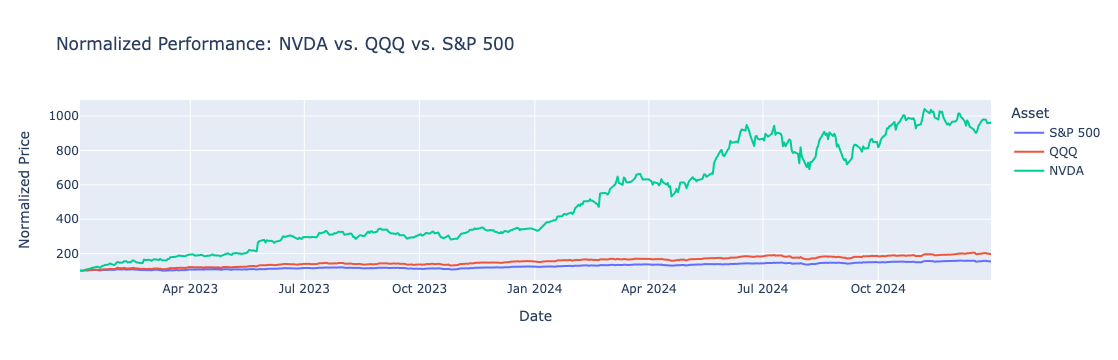

In [29]:

def visual1():
    df1 = data_parser()     
    df2 = web_parser2()     

    df1 = df1.reset_index()
    df2 = df2.reset_index()
    df1['Date'] = pd.to_datetime(df1['Date'])
    df2['Date'] = pd.to_datetime(df2['Date'])

    
    merged = pd.merge(df1, df2, on='Date')

    
    filtered = merged[['Date', 'S&P 500', 'QQQ', 'NVDA']]

    normalized = filtered.set_index('Date').apply(lambda x: x / x.iloc[0] * 100)
    normalized = normalized.reset_index()

    
    fig = px.line(
        normalized,
        x='Date',
        
        y=['S&P 500', 'QQQ', 'NVDA'],
        title='Normalized Performance: NVDA vs. QQQ vs. S&P 500',
        labels={'value': 'Normalized Price', 'variable': 'Asset'},
    )
    fig.show()




############ Function Call ############
visual1()

This visualization compares the normalized performance of NVIDIA stock, QQQ (a tech-heavy ETF) and the S&P 500 (representing the broader market index) over the years 2023 and 2024. By normalizing all closing prices to start at 100, differences in absolute price are elimnated and instead the graph highlights percentage growth, making it easier to visualize trends. 

From the chart, its clear that NVIDIA has outperformed both QQQ and S&P 500 tremendously. As we can see in the chart, NVIDIA's closing price experienced steep upward movement while QQQ and S&P had steady and modest growth. 

This shows the exceptional performance of NVIDIA relative to the broader market. Also, it supports the idea that NVIDIA has led the tech wave. 


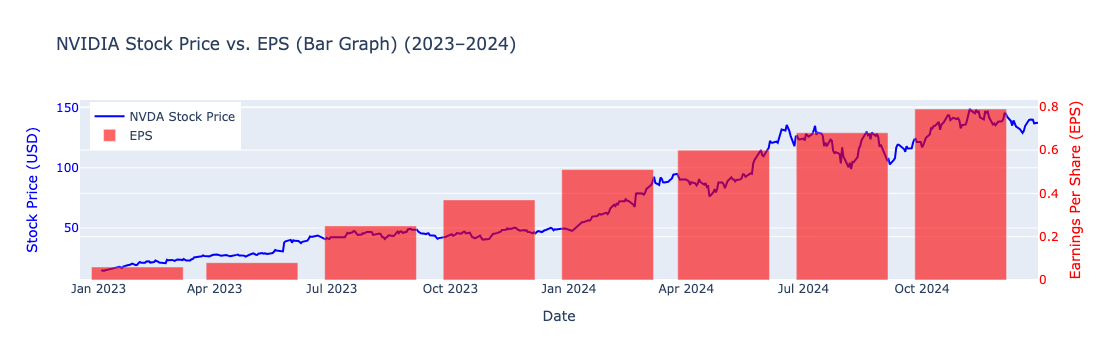

In [30]:
import plotly.graph_objs as py
import pandas as pd

def visual2():
    stock = pd.read_csv('nvda_stock.csv') 
    income = pd.read_csv('nvda_income.csv', index_col=0) #loading in the dfs

    stock['Date'] = pd.to_datetime(stock['Date'])
    income.index = pd.to_datetime(income.index) #formatitng

    #use dual axis y in order to plot both y values over dates as a x axis
    stockgraph = py.Scatter( x= stock["Date"], y = stock["NVDA"], mode = 'lines',name = 'NVDA Stock Price',line = dict(color='blue'),
                            yaxis = 'y1')

    #bar chart to represent eps
    epsgraph = py.Bar(x=income.index, y=income['Basic EPS'], name='EPS', marker=dict(color='red'), yaxis='y2',opacity=0.6)

    #stock price on left axis, eps on right axis
    layout = py.Layout(title='NVIDIA Stock Price vs. EPS (Bar Graph) (2023–2024)',xaxis=dict(title='Date'),
                       yaxis=dict(title='Stock Price (USD)',titlefont=dict(color='blue'),tickfont=dict(color='blue')),
                       yaxis2=dict(title='Earnings Per Share (EPS)',titlefont=dict(color='red'),tickfont=dict(color='red'),overlaying='y',
                                   side='right'),
                       legend=dict(x=0.01, y=0.99),hovermode='x unified')
    
    #show figure 
    fig = py.Figure(data=[stockgraph, epsgraph], layout=layout)
    fig.show()





############ Function Call ############
visual2()

This visualization uses a dual-axis chart to show the relationship between NVIDIA’s stock price and its Earnings Per Share (EPS) over time. The left axis represents NVDA’s daily stock price, while the right axis plots quarterly EPS as a red-dashed line with markers. The graph reveals that the stock price closely follows the upward trend in earnings, suggesting that strong financial performance drives investor confidence. EPS increases steadily, indicating consistent profitability growth, which appears to be mirrored in the stock price. Interestingly, price movements often precede earnings announcements, highlighting the role of investor anticipation and market sentiment.

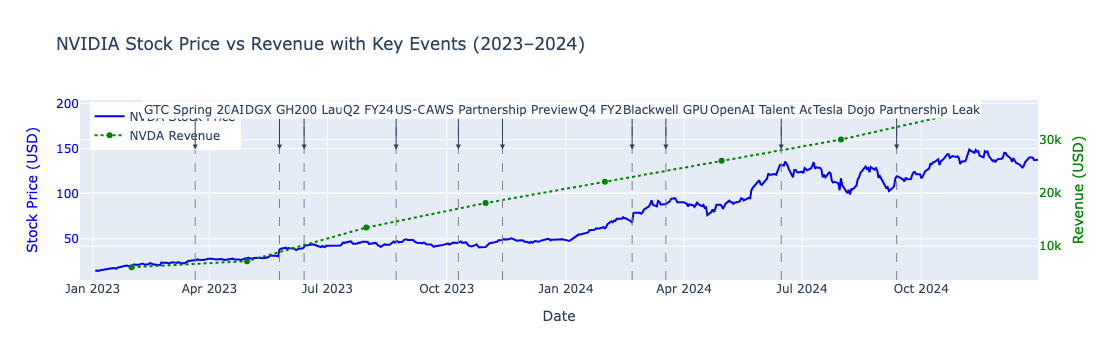

In [31]:
def visual3():
    stock = pd.read_csv('nvda_stock.csv')
    stock['Date'] = pd.to_datetime(stock['Date'])
    #stock = stock[(stock['Date'] >= '2023-01-01') & (stock['Date'] <= '2024-12-31')]

    income = pd.read_csv('nvda_income.csv', index_col=0)
    income.index = pd.to_datetime(income.index)
    #income = income[(income.index >= '2023-01-01') & (income.index <= '2024-12-31')]

    #use dual y-axis to plot revenue and stock price
    # use scatted plot for stock price (on a daily basis)
    stockgraph = py.Scatter(x=stock['Date'], y=stock['NVDA'], mode='lines', name='NVDA Stock Price', line=dict(color='blue'), yaxis='y1')

    # use scatter plot for revenue nvda as markers
    revenuegraph = py.Scatter(x=income.index, y=income['Revenue'], mode='lines+markers', name='NVDA Revenue', line=dict(color='green', dash='dot'), yaxis='y2')

    # events we want to highlight and look at 
    events = [
        ("2023-03-21", "GTC Spring 2023"),
        ("2023-05-25", "AI Market Boom"),
        ("2023-06-13", "DGX GH200 Launch"),
        ("2023-08-23", "Q2 FY24 Earnings"),
        ("2023-10-10", "US-China Export Ban"),
        ("2023-11-13", "AWS Partnership Preview"),
        ("2024-02-21", "Q4 FY24 Earnings"),
        ("2024-03-18", "Blackwell GPU"),
        ("2024-06-15", "OpenAI Talent Acquired"),
        ("2024-09-12", "Tesla Dojo Partnership Leak"),
    ]

    shapes = []
    markers = []
    #make events

    for datestr, label in events:
        date = pd.to_datetime(datestr)
        if stock['Date'].min() <= date <= stock['Date'].max():
            shapes.append(dict(type='line',x0=date, x1=date,y0=0, y1=1,yref='paper',line=dict(color='gray', width=1, dash='dash')))
            markers.append(dict(x=date,y=max(stock['NVDA']),xref='x',yref='y1',text=label,showarrow=True,arrowhead=2,ax=0,ay=-40,
                                bgcolor='white')) #searched up how to show arrows
    #use arrows to show markers for each event and label them  so they stand out amongst other dates

    # Layout
    layout = py.Layout(title='NVIDIA Stock Price vs Revenue with Key Events (2023–2024)', xaxis=dict(title='Date'),
                       yaxis=dict(title='Stock Price (USD)',titlefont=dict(color='blue'),tickfont=dict(color='blue')),
                       yaxis2=dict(title='Revenue (USD)',titlefont=dict(color='green'),tickfont=dict(color='green'),overlaying='y',
                                   side='right'),
                       legend=dict(x=0.01, y=0.99),hovermode='x unified',shapes=shapes,annotations=markers) 
    #layout of each chart & events inclusion

    # final figure
    fig = py.Figure(data=[stockgraph, revenuegraph], layout=layout)
    fig.show()





############ Function Call ############
visual3()

This visualization shows how major market and tech industry events influenced NVIDIA’s stock price and revenue during 2023–2024, using a dual-axis chart. The blue line (left axis) represents NVDA’s stock price, while the green dashed line (right axis) shows revenue, with annotated arrow markers highlighting key events. Earnings announcements consistently impact stock price, especially in Q4 FY24, where a revenue spike coincides with EPS beating analyst expectations. Another key moment is the AI market boom in May 2023, where NVIDIA’s stock price surged sharply, reflecting its leadership in the AI space. These trends demonstrate how both earnings and industry momentum directly affect NVIDIA’s financial performance and market valuation.